## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [ ]:
!pip install torchvision

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
device

'cuda:0'

In [3]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [4]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



In [5]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [6]:
len(fmnist_dataset_test)

10000

In [7]:
len(fmnist_dataset_train)

60000

In [8]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [15]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, num_classes * 5),
            nn.BatchNorm1d(num_classes * 5),
            nn.ReLU(),
            nn.Dropout1d(p=0.4),
            nn.Linear(num_classes * 5, num_classes * 3),
            nn.BatchNorm1d(num_classes * 3),
            nn.ReLU(),
            nn.Dropout1d(p=0.4),
            nn.Linear(num_classes * 3, num_classes),
            nn.LogSoftmax()
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [16]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 50]          39,250
       BatchNorm1d-3                   [-1, 50]             100
              ReLU-4                   [-1, 50]               0
         Dropout1d-5                   [-1, 50]               0
            Linear-6                   [-1, 30]           1,530
       BatchNorm1d-7                   [-1, 30]              60
              ReLU-8                   [-1, 30]               0
         Dropout1d-9                   [-1, 30]               0
           Linear-10                   [-1, 10]             310
       LogSoftmax-11                   [-1, 10]               0
Total params: 41,250
Trainable params: 41,250
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Your experiments come here:

In [17]:
from tqdm import tqdm

In [18]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

In [22]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(params=model.parameters(), lr=5e-3) # YOUR CODE HERE
loss_func = nn.NLLLoss() # YOUR CODE HERE

# Your experiments, training and validation loops here
epochs = 40

train_losses = [] # for each epoch
val_losses = [] # for each epoch

pbar = tqdm(range(epochs), desc='Total')
for i in pbar:
    pbar.set_description(
        f'Loss: {0.0 if len(train_losses) == 0 else train_losses[-1]}'
    )

    model.train()
    train_loss_epoch = []
    for X_batch, y_batch in train_loader:
        opt.zero_grad()
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        probs = model(X_batch)
        loss = loss_func(probs, y_batch)
        loss.backward()
        opt.step()
        train_loss_epoch.append(loss.item())
    
    train_losses.append(np.mean(train_loss_epoch))
    
    model.eval()
    train_loss_epoch = []
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
                
        probs = model(X_batch)
        loss = loss_func(probs, y_batch)
        train_loss_epoch.append(loss.item())
        
    val_losses.append(np.mean(train_loss_epoch))

Loss: 1.533329911069321: 100%|██████████| 40/40 [05:45<00:00,  8.64s/it]


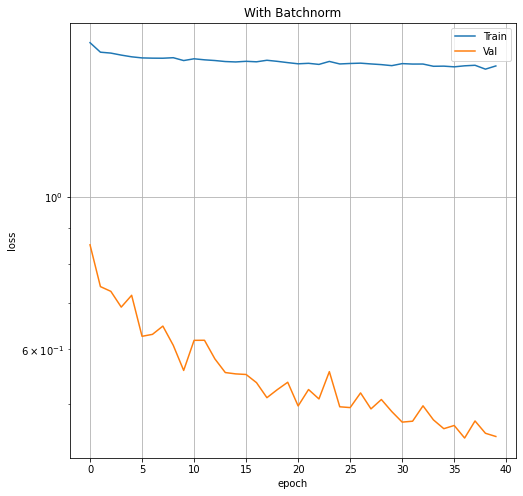

In [23]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
    
plt.title('With Batchnorm')

plt.xlabel('epoch')
plt.ylabel('loss')
plt.yscale('log')

plt.plot(range(epochs), torch.Tensor(train_losses), label='Train')
plt.plot(range(epochs), torch.Tensor(val_losses), label='Val')
plt.grid()
plt.legend()

In [35]:
test_accuracy = 0.0
correct, total = 0, 0

for X_batch, y_batch in test_loader:
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
        
    probs = model(X_batch)
    preds = probs.argmax(axis=1)
    correct += (preds == y_batch).sum().item()
    total += len(y_batch)

test_accuracy = correct / total

print('Test accuracy:', test_accuracy)

Test accuracy: 0.88


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

Here we can try just remove dropout and batchnormalization, increase number of neurons in hidden layers and increase the number of this layers.

In [36]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, num_classes * 20),
            nn.ReLU(),
            nn.Linear(num_classes * 20, num_classes * 20),
            nn.ReLU(),
            nn.Linear(num_classes * 20, num_classes * 20),
            nn.ReLU(),
            nn.Linear(num_classes * 20, num_classes * 20),
            nn.ReLU(),
            nn.Linear(num_classes * 20, num_classes),
            nn.LogSoftmax()
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [37]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 200]         157,000
              ReLU-3                  [-1, 200]               0
            Linear-4                  [-1, 200]          40,200
              ReLU-5                  [-1, 200]               0
            Linear-6                  [-1, 200]          40,200
              ReLU-7                  [-1, 200]               0
            Linear-8                  [-1, 200]          40,200
              ReLU-9                  [-1, 200]               0
           Linear-10                   [-1, 10]           2,010
       LogSoftmax-11                   [-1, 10]               0
Total params: 279,610
Trainable params: 279,610
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [39]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(params=model.parameters(), lr=5e-3) # YOUR CODE HERE
loss_func = nn.NLLLoss() # YOUR CODE HERE

# Your experiments, come here
epochs = 40

train_losses = [] # for each epoch
val_losses = [] # for each epoch

pbar = tqdm(range(epochs), desc='Total')
for i in pbar:
    pbar.set_description(
        f'Loss: {0.0 if len(train_losses) == 0 else train_losses[-1]}'
    )

    model.train()
    train_loss_epoch = []
    for X_batch, y_batch in train_loader:
        opt.zero_grad()
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        probs = model(X_batch)
        loss = loss_func(probs, y_batch)
        loss.backward()
        opt.step()
        train_loss_epoch.append(loss.item())
    
    train_losses.append(np.mean(train_loss_epoch))
    
    model.eval()
    train_loss_epoch = []
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
                
        probs = model(X_batch)
        loss = loss_func(probs, y_batch)
        train_loss_epoch.append(loss.item())
        
    val_losses.append(np.mean(train_loss_epoch))

Loss: 0.20436815302699868: 100%|██████████| 40/40 [05:33<00:00,  8.34s/it]


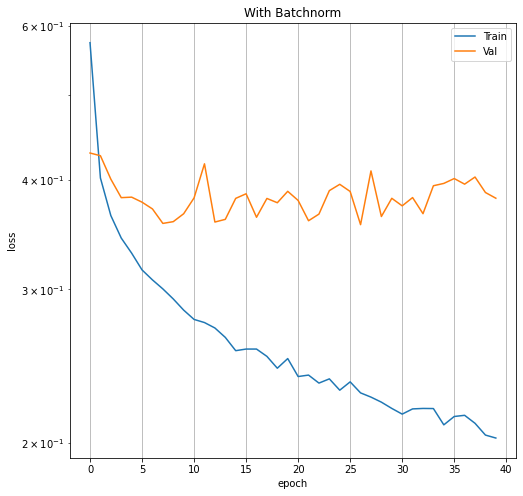

In [40]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
    
plt.title('With Batchnorm')

plt.xlabel('epoch')
plt.ylabel('loss')
plt.yscale('log')

plt.plot(range(epochs), torch.Tensor(train_losses), label='Train')
plt.plot(range(epochs), torch.Tensor(val_losses), label='Val')
plt.grid()
plt.legend()

In [43]:
test_accuracy = 0.0
correct, total = 0, 0

for X_batch, y_batch in train_loader:
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
        
    probs = model(X_batch)
    preds = probs.argmax(axis=1)
    correct += (preds == y_batch).sum().item()
    total += len(y_batch)

train_accuracy = correct / total

print('Train accuracy:', train_accuracy)

Train accuracy: 0.9325333333333333


In [41]:
test_accuracy = 0.0
correct, total = 0, 0

for X_batch, y_batch in test_loader:
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
        
    probs = model(X_batch)
    preds = probs.argmax(axis=1)
    correct += (preds == y_batch).sum().item()
    total += len(y_batch)

test_accuracy = correct / total

print('Test accuracy:', test_accuracy)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Test accuracy: 0.8862


### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [47]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, num_classes * 20),
            nn.BatchNorm1d(num_classes * 20),
            nn.ReLU(),
            nn.Dropout1d(p=0.5),
            nn.Linear(num_classes * 20, num_classes * 20),
            nn.BatchNorm1d(num_classes * 20),
            nn.ReLU(),
            nn.Dropout1d(p=0.5),
            nn.Linear(num_classes * 20, num_classes * 20),
            nn.BatchNorm1d(num_classes * 20),
            nn.ReLU(),
            nn.Dropout1d(p=0.5),
            nn.Linear(num_classes * 20, num_classes * 20),
            nn.BatchNorm1d(num_classes * 20),
            nn.ReLU(),
            nn.Dropout1d(p=0.5),
            nn.Linear(num_classes * 20, num_classes),
            nn.LogSoftmax()
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [48]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 200]         157,000
       BatchNorm1d-3                  [-1, 200]             400
              ReLU-4                  [-1, 200]               0
         Dropout1d-5                  [-1, 200]               0
            Linear-6                  [-1, 200]          40,200
       BatchNorm1d-7                  [-1, 200]             400
              ReLU-8                  [-1, 200]               0
         Dropout1d-9                  [-1, 200]               0
           Linear-10                  [-1, 200]          40,200
      BatchNorm1d-11                  [-1, 200]             400
             ReLU-12                  [-1, 200]               0
        Dropout1d-13                  [-1, 200]               0
           Linear-14                  [

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [49]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(params=model.parameters(), lr=5e-3) # YOUR CODE HERE
loss_func = nn.NLLLoss() # YOUR CODE HERE

# Your experiments, come here
epochs = 40

train_losses = [] # for each epoch
val_losses = [] # for each epoch

pbar = tqdm(range(epochs), desc='Total')
for i in pbar:
    pbar.set_description(
        f'Loss: {0.0 if len(train_losses) == 0 else train_losses[-1]}'
    )

    model.train()
    train_loss_epoch = []
    for X_batch, y_batch in train_loader:
        opt.zero_grad()
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        probs = model(X_batch)
        loss = loss_func(probs, y_batch)
        loss.backward()
        opt.step()
        train_loss_epoch.append(loss.item())
    
    train_losses.append(np.mean(train_loss_epoch))
    
    model.eval()
    train_loss_epoch = []
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
                
        probs = model(X_batch)
        loss = loss_func(probs, y_batch)
        train_loss_epoch.append(loss.item())
        
    val_losses.append(np.mean(train_loss_epoch))

Loss: 2.182829376476914:  72%|███████▎  | 29/40 [04:28<01:41,  9.23s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe72b241c10>
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe72b241c10>  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    
self._shutdown_workers()  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers

    Traceback (most recent call last):
if w.is_alive():  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__

  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
        self._shutdown_workers()assert self._parent_pid == os.getpid(), 'can only test a child process'

AssertionError  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1449, in _shutdown_workers
:  

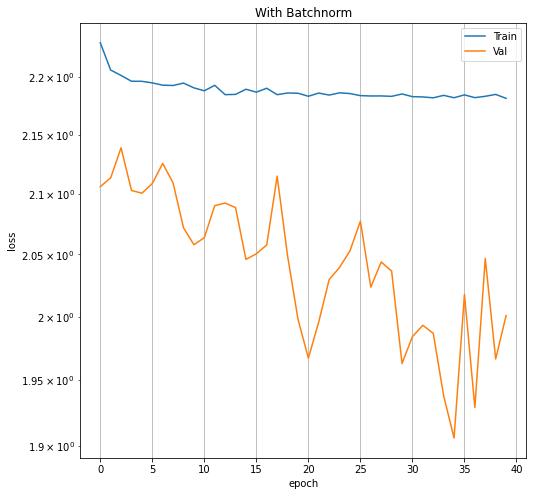

In [50]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
    
plt.title('With Batchnorm')

plt.xlabel('epoch')
plt.ylabel('loss')
plt.yscale('log')

plt.plot(range(epochs), torch.Tensor(train_losses), label='Train')
plt.plot(range(epochs), torch.Tensor(val_losses), label='Val')
plt.grid()
plt.legend()

In [51]:
test_accuracy = 0.0
correct, total = 0, 0

for X_batch, y_batch in train_loader:
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
        
    probs = model(X_batch)
    preds = probs.argmax(axis=1)
    correct += (preds == y_batch).sum().item()
    total += len(y_batch)

train_accuracy = correct / total

print('Train accuracy:', train_accuracy)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train accuracy: 0.8172166666666667


In [52]:
test_accuracy = 0.0
correct, total = 0, 0

for X_batch, y_batch in test_loader:
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
        
    probs = model(X_batch)
    preds = probs.argmax(axis=1)
    correct += (preds == y_batch).sum().item()
    total += len(y_batch)

test_accuracy = correct / total

print('Test accuracy:', test_accuracy)

Test accuracy: 0.8019


### Conclusions:
_Write down small report with your conclusions and your ideas._

It is clear that in Overfitten model their is overfittness (haha). Look at the accuracy scores on train and test samples. The difference is almost 0.05.

But if we use dropout, Batch normalization, then like as usual the quality is less both on train and test, but the result is more stable. The difference between train and test in terms of accuracy for fixed model is about 0.015.

The idea is simple: regularization can prevent overfitting, like in conventional models.